The basic expiremental setup here is we have a stock dataset for the price of GOOG for 50 different samples. Each sample represents a sequence of 10 prices of GOOG in the stock market that are ordered timewise.
The columns in the dataset are [seq_id,	seq_time_id, seq_temporal_Close, seq_temporal_High,	seq_temporal_Low, seq_temporal_Open, seq_temporal_Volume, seq_out_Open_next]. All the columns represent temporal data except seq_id which is the id of the current sample and seq_out_Open_next which represents the open of the next day. I'm using all the columns to predict the close of the stock price in the 10th sample given. I'm using an LSTM layer with a dropout and then a linear layer to produce the close since this data isn't too complex. I trained the model with Adam and MSE loss.

In [2]:
import matplotlib.pyplot as plt

In [ ]:
import sys
from os.path import dirname
sys.path.append(dirname('./synthcity/src/'))

In [4]:
import torch
import torch.nn as nn
import numpy as np

C:\Users\ma7mo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader

In [7]:
import seaborn as sns

In [8]:
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [9]:
Plugins(categories=["time_series"]).list()

['timevae', 'timegan', 'fflows']

In [10]:
from synthcity.utils.datasets.time_series.pbc import PBCDataloader
from synthcity.utils.datasets.time_series.google_stocks import GoogleStocksDataloader
from synthcity.plugins.core.dataloader import TimeSeriesDataLoader

In [11]:
static_data, temporal_data, horizons, outcome = GoogleStocksDataloader().load()

In [12]:
data = TimeSeriesDataLoader(
    temporal_data=temporal_data,
    observation_times=horizons,
    static_data=static_data,
    outcome=outcome,
)

In [13]:
data

,seq_id,seq_time_id,seq_temporal_Close,seq_temporal_High,seq_temporal_Low,seq_temporal_Open,seq_temporal_Volume,seq_out_Open_next
0,0,0.261364,0.449439,0.359247,0.403651,0.359753,0.166763,0.710852
1,0,0.250000,0.410585,0.373123,0.431552,0.399038,0.211437,0.710852
2,0,0.238636,0.433749,0.384961,0.422686,0.378984,0.249088,0.710852
3,0,0.204545,0.427522,0.355707,0.284146,0.225962,0.382690,0.710852
4,0,0.193182,0.276463,0.165675,0.190483,0.099863,0.265592,0.710852
...,...,...,...,...,...,...,...,...
495,49,0.670455,0.651805,0.589351,0.633246,0.564835,0.252658,0.246566
496,49,0.659091,0.587297,0.569527,0.626597,0.557005,0.261217,0.246566
497,49,0.647727,0.605604,0.569527,0.594394,0.552061,0.165112,0.246566
498,49,0.636364,0.590535,0.540625,0.587745,0.510852,0.220572,0.246566


In [12]:
delta = 1/ (len(data) * np.log(len(data)))

In [13]:
syn_model_without_dp = Plugins().get("timegan", dp_enabled=False)

[2023-09-05T13:12:42.352173-0400][8876][CRITICAL] load failed: 
arfpy is not installed. Please install it with pip install arfpy.
Please be aware that arfpy is only available for python >= 3.8.

[2023-09-05T13:12:42.352173-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:42.353172-0400][8876][CRITICAL] module plugin_arf load failed
[2023-09-05T13:12:42.675656-0400][8876][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthcity/src\synthcity\plugins\generic\plugin_goggle.py
[2023-09-05T13:12:42.676604-0400][8876][CRITICAL] load failed: 
GReaT is not installed. Please install it with pip install GReaT.
Please be aware that GReaT is only available for python >= 3.9.

[2023-09-05T13:12:42.676604-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2023-09-05T13:12:42.677603-0400][8876][CRITICAL] module plugin_great load failed


In [14]:
syn_model_with_dp_eps1 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=1., delta = delta)

[2023-09-05T13:12:43.222493-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.222493-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.223494-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.223494-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.224494-0400][8876][CRITICAL] module plugin_arf load failed
[2023-09-05T13:12:43.224494-0400][8876][CRITICAL] module plugin_arf load failed
[2023-09-05T13:12:43.225494-0400][8876][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthcity/src\synthcity\plugins\generic\plugin_goggle.py
[2023-09-05T13:12:43.225494-0400][8876][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthci

In [15]:
syn_model_with_dp_eps5 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=5., delta = delta)

[2023-09-05T13:12:43.238648-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.238648-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.239649-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.239649-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.240648-0400][8876][CRITICAL] module plugin_arf load failed
[2023-09-05T13:12:43.240648-0400][8876][CRITICAL] module plugin_arf load failed
[2023-09-05T13:12:43.240648-0400][8876][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthcity/src\synthcity\plugins\generic\plugin_goggle.py
[2023-09-05T13:12:43.240648-0400][8876][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthci

In [16]:
syn_model_with_dp_eps20 = Plugins().get("timegan", mode="DPRNN", dp_enabled=True, n_iter=300, epsilon=20., delta = delta)

[2023-09-05T13:12:43.254875-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.254875-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.255877-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.255877-0400][8876][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_arf' has no attribute 'plugin'
[2023-09-05T13:12:43.256875-0400][8876][CRITICAL] module plugin_arf load failed
[2023-09-05T13:12:43.256875-0400][8876][CRITICAL] module plugin_arf load failed
[2023-09-05T13:12:43.257875-0400][8876][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthcity/src\synthcity\plugins\generic\plugin_goggle.py
[2023-09-05T13:12:43.257875-0400][8876][CRITICAL] module disabled: C:\Users\ma7mo\Desktop\synthetic_time_series\src\./synthci

In [17]:
syn_model_without_dp.fit(data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:14<00:00,  2.30it/s]


In [18]:
syn_model_with_dp_eps1.fit(data)

Enabling DP Privacy Engine: epsilon= 1.0 delta= 0.00032182238498800495 max_grad_norm= 2.0 secure_mode= False


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [31:34<00:00,  6.32s/it]


In [19]:
syn_model_with_dp_eps5.fit(data)

Enabling DP Privacy Engine: epsilon= 5.0 delta= 0.00032182238498800495 max_grad_norm= 2.0 secure_mode= False


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [1:29:26<00:00, 17.89s/it]


In [20]:
syn_model_with_dp_eps20.fit(data)

Enabling DP Privacy Engine: epsilon= 20.0 delta= 0.00032182238498800495 max_grad_norm= 2.0 secure_mode= False


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [2:38:53<00:00, 31.78s/it]


In [21]:
synth_data_without_dp = syn_model_without_dp.generate(count=len(data)/10)

In [22]:
synth_data_with_dp = syn_model_with_dp_eps1.generate(count=len(data)/10)

In [23]:
synth_data_with_dp_eps5 = syn_model_with_dp_eps5.generate(count=len(data)/10)

In [24]:
synth_data_with_dp_eps20 = syn_model_with_dp_eps20.generate(count=len(data)/10)

In [25]:
def create_sequence(dataset, seq_len):
    sequences = []
    labels = []


    for index in range(0, len(dataset)//seq_len): # Selecting 50 rows at a time
        sequences.append(dataset.iloc[index*seq_len:(index+1)*seq_len-1])
        labels.append(dataset.iloc[(index+1)*seq_len-1][2])
    return (np.array(sequences),np.array(labels))

In [26]:
def create_sequence_np(dataset, seq_len):
    sequences = []
    labels = []
    for index in range(0, len(dataset)): # Selecting 50 rows at a time
        sequences.append(dataset[index][:-1])
        labels.append(dataset[index][-1][2])
    return (np.array(sequences),np.array(labels))

In [65]:
class Network(nn.Module):
    def __init__(self, dropout,
                 input_dim=8, num_classes = 1, hidden_size = 10, **kwargs):

        super(Network, self).__init__()

        print("==> not used params in network class:", kwargs.keys())

        self.input_dim = input_dim
        self.dropout = dropout
        self.hidden_size = hidden_size


        # Main part of the network
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_size=input_dim,hidden_size=self.hidden_size))
        self.lstm_layers.append(nn.Dropout(p=dropout))
        # self.lstm_layers.append(nn.LSTM(input_size=self.hidden_size,
        #                    hidden_size=self.hidden_size))
        # self.lstm_layers.append(nn.Dropout(p=dropout))
        # self.lstm_layers.append(nn.LSTM(input_size=self.hidden_size,
        #                    hidden_size=self.hidden_size))
        # self.lstm_layers.append(nn.Dropout(p=dropout))
        # Output layer
        self.output_layer = nn.Linear(self.hidden_size, num_classes)
        # self.output_activation = nn.Sigmoid()

    def forward(self, X, lengths=None):
        # Input layer
        X = X.to(torch.float32)
        mX = X
        # Main part of the network
        i = 0
        for lstm in self.lstm_layers:
            if i % 2 == 0:
                output, _ = lstm(mX)
            else:
                output = lstm(mX)
            mX = output
            i += 1
        L = output[:, -1, :]
        # Output layer
        y = self.output_layer(L)
        return y


In [66]:
def run_model(model, training_error, testing_error, X_train, y_train, X_test, y_test):
    loss = nn.MSELoss()
    train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=1)
    val_loader = DataLoader(list(zip(X_test, y_test)), batch_size=1, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    for epoch in range(0, 100):
        model.train()
        step_loss = []
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            outputs = model(inputs)
            targets = targets.reshape(tuple(outputs.shape))
            targets = targets.to(torch.float32)
            batch_loss = loss(outputs, targets)
            batch_loss.backward()
            optimizer.step()
            step_loss.append(batch_loss.item())
        training_error.append(np.array(step_loss).mean())
        model.eval()
        val_loss = 0
        with torch.no_grad():
            num_batches = 0
            res = {}
            y_true = []
            predictions = []
            for batch in val_loader:
                inputs, targets = batch
                outputs = model(inputs)
                targets = targets.reshape(tuple(outputs.shape))
                targets = targets.to(torch.float32)
                batch_loss = loss(outputs, targets)
                val_loss += batch_loss.item()
                num_batches += 1
            val_loss /= num_batches
            print('Epoch [{}/{}], Step [{}/{}], Validation Batch Loss: {:.4f}'
                    .format(epoch + 1, 100, i + 1, len(train_loader), val_loss))
        testing_error.append(val_loss)

In [46]:
random_data = np.random.rand(40, 10, 8)

In [47]:
X, y = create_sequence(data.dataframe(), 10)

In [48]:
synth_no_dp_X, synth_no_dp_y = create_sequence(synth_data_without_dp.dataframe(), 10)

In [49]:
synth_dp_X, synth_dp_y = create_sequence(synth_data_with_dp.dataframe(), 10)

In [50]:
synth_dp_eps5_X, synth_dp_eps5_y = create_sequence(synth_data_with_dp_eps5.dataframe(), 10)

In [51]:
synth_dp_eps20_X, synth_dp_eps20_y = create_sequence(synth_data_with_dp_eps20.dataframe(), 10)

In [52]:
random_X, random_y = create_sequence_np(random_data, 10)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [67]:
model = Network(0.2)
trainingEpoch_loss = []
validationEpoch_loss = []
run_model(model, trainingEpoch_loss, validationEpoch_loss, X_train, y_train, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [33/33], Validation Batch Loss: 0.1573
Epoch [2/100], Step [33/33], Validation Batch Loss: 0.0753
Epoch [3/100], Step [33/33], Validation Batch Loss: 0.0459
Epoch [4/100], Step [33/33], Validation Batch Loss: 0.0334
Epoch [5/100], Step [33/33], Validation Batch Loss: 0.0285
Epoch [6/100], Step [33/33], Validation Batch Loss: 0.0270
Epoch [7/100], Step [33/33], Validation Batch Loss: 0.0265
Epoch [8/100], Step [33/33], Validation Batch Loss: 0.0264
Epoch [9/100], Step [33/33], Validation Batch Loss: 0.0251
Epoch [10/100], Step [33/33], Validation Batch Loss: 0.0249
Epoch [11/100], Step [33/33], Validation Batch Loss: 0.0249
Epoch [12/100], Step [33/33], Validation Batch Loss: 0.0252
Epoch [13/100], Step [33/33], Validation Batch Loss: 0.0260
Epoch [14/100], Step [33/33], Validation Batch Loss: 0.0254
Epoch [15/100], Step [33/33], Validation Batch Loss: 0.0257
Epoch [16/100], Step [33/33], Validation Batch Loss: 0.02

In [68]:
synth_no_dp_model = Network(0.2)
trainingEpoch_no_dp_loss = []
validationEpoch_no_dp_loss = []
run_model(synth_no_dp_model, trainingEpoch_no_dp_loss, validationEpoch_no_dp_loss, synth_no_dp_X, synth_no_dp_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [50/50], Validation Batch Loss: 0.1185
Epoch [2/100], Step [50/50], Validation Batch Loss: 0.0502
Epoch [3/100], Step [50/50], Validation Batch Loss: 0.0359
Epoch [4/100], Step [50/50], Validation Batch Loss: 0.0334
Epoch [5/100], Step [50/50], Validation Batch Loss: 0.0335
Epoch [6/100], Step [50/50], Validation Batch Loss: 0.0333
Epoch [7/100], Step [50/50], Validation Batch Loss: 0.0338
Epoch [8/100], Step [50/50], Validation Batch Loss: 0.0336
Epoch [9/100], Step [50/50], Validation Batch Loss: 0.0334
Epoch [10/100], Step [50/50], Validation Batch Loss: 0.0340
Epoch [11/100], Step [50/50], Validation Batch Loss: 0.0328
Epoch [12/100], Step [50/50], Validation Batch Loss: 0.0312
Epoch [13/100], Step [50/50], Validation Batch Loss: 0.0312
Epoch [14/100], Step [50/50], Validation Batch Loss: 0.0299
Epoch [15/100], Step [50/50], Validation Batch Loss: 0.0284
Epoch [16/100], Step [50/50], Validation Batch Loss: 0.02

In [69]:
synth_dp_model = Network(0.2)
trainingEpoch_dp_loss = []
validationEpoch_dp_loss = []
run_model(synth_dp_model, trainingEpoch_dp_loss, validationEpoch_dp_loss, synth_dp_X, synth_dp_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [50/50], Validation Batch Loss: 0.0635
Epoch [2/100], Step [50/50], Validation Batch Loss: 0.0329
Epoch [3/100], Step [50/50], Validation Batch Loss: 0.0332
Epoch [4/100], Step [50/50], Validation Batch Loss: 0.0345
Epoch [5/100], Step [50/50], Validation Batch Loss: 0.0367
Epoch [6/100], Step [50/50], Validation Batch Loss: 0.0347
Epoch [7/100], Step [50/50], Validation Batch Loss: 0.0345
Epoch [8/100], Step [50/50], Validation Batch Loss: 0.0357
Epoch [9/100], Step [50/50], Validation Batch Loss: 0.0365
Epoch [10/100], Step [50/50], Validation Batch Loss: 0.0363
Epoch [11/100], Step [50/50], Validation Batch Loss: 0.0376
Epoch [12/100], Step [50/50], Validation Batch Loss: 0.0358
Epoch [13/100], Step [50/50], Validation Batch Loss: 0.0353
Epoch [14/100], Step [50/50], Validation Batch Loss: 0.0362
Epoch [15/100], Step [50/50], Validation Batch Loss: 0.0358
Epoch [16/100], Step [50/50], Validation Batch Loss: 0.03

In [61]:
synth_dp_eps5_model = Network(0.2)
trainingEpoch_dp_eps5_loss = []
validationEpoch_dp_eps5_loss = []
run_model(synth_dp_eps5_model, trainingEpoch_dp_eps5_loss, validationEpoch_dp_eps5_loss, synth_dp_eps5_X, synth_dp_eps5_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [50/50], Validation Batch Loss: 0.0396
Epoch [2/100], Step [50/50], Validation Batch Loss: 0.0356
Epoch [3/100], Step [50/50], Validation Batch Loss: 0.0401
Epoch [4/100], Step [50/50], Validation Batch Loss: 0.0403
Epoch [5/100], Step [50/50], Validation Batch Loss: 0.0409
Epoch [6/100], Step [50/50], Validation Batch Loss: 0.0396
Epoch [7/100], Step [50/50], Validation Batch Loss: 0.0396
Epoch [8/100], Step [50/50], Validation Batch Loss: 0.0396
Epoch [9/100], Step [50/50], Validation Batch Loss: 0.0398
Epoch [10/100], Step [50/50], Validation Batch Loss: 0.0401
Epoch [11/100], Step [50/50], Validation Batch Loss: 0.0401
Epoch [12/100], Step [50/50], Validation Batch Loss: 0.0401
Epoch [13/100], Step [50/50], Validation Batch Loss: 0.0405
Epoch [14/100], Step [50/50], Validation Batch Loss: 0.0389
Epoch [15/100], Step [50/50], Validation Batch Loss: 0.0397
Epoch [16/100], Step [50/50], Validation Batch Loss: 0.03

In [62]:
synth_dp_eps20_model = Network(0.2)
trainingEpoch_dp_eps20_loss = []
validationEpoch_dp_eps20_loss = []
run_model(synth_dp_eps20_model, trainingEpoch_dp_eps20_loss, validationEpoch_dp_eps20_loss, synth_dp_eps20_X, synth_dp_eps20_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [49/49], Validation Batch Loss: 0.0759
Epoch [2/100], Step [49/49], Validation Batch Loss: 0.0346
Epoch [3/100], Step [49/49], Validation Batch Loss: 0.0390
Epoch [4/100], Step [49/49], Validation Batch Loss: 0.0435
Epoch [5/100], Step [49/49], Validation Batch Loss: 0.0408
Epoch [6/100], Step [49/49], Validation Batch Loss: 0.0429
Epoch [7/100], Step [49/49], Validation Batch Loss: 0.0423
Epoch [8/100], Step [49/49], Validation Batch Loss: 0.0437
Epoch [9/100], Step [49/49], Validation Batch Loss: 0.0434
Epoch [10/100], Step [49/49], Validation Batch Loss: 0.0426
Epoch [11/100], Step [49/49], Validation Batch Loss: 0.0439
Epoch [12/100], Step [49/49], Validation Batch Loss: 0.0432
Epoch [13/100], Step [49/49], Validation Batch Loss: 0.0489
Epoch [14/100], Step [49/49], Validation Batch Loss: 0.0441
Epoch [15/100], Step [49/49], Validation Batch Loss: 0.0460
Epoch [16/100], Step [49/49], Validation Batch Loss: 0.04

In [63]:
random_model = Network(0.2)
trainingEpoch_random_loss = []
validationEpoch_random_loss = []
run_model(random_model, trainingEpoch_random_loss, validationEpoch_random_loss, random_X, random_y, X_test, y_test)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [40/40], Validation Batch Loss: 0.3844
Epoch [2/100], Step [40/40], Validation Batch Loss: 0.2750
Epoch [3/100], Step [40/40], Validation Batch Loss: 0.1035
Epoch [4/100], Step [40/40], Validation Batch Loss: 0.0314
Epoch [5/100], Step [40/40], Validation Batch Loss: 0.0352
Epoch [6/100], Step [40/40], Validation Batch Loss: 0.0378
Epoch [7/100], Step [40/40], Validation Batch Loss: 0.0419
Epoch [8/100], Step [40/40], Validation Batch Loss: 0.0396
Epoch [9/100], Step [40/40], Validation Batch Loss: 0.0401
Epoch [10/100], Step [40/40], Validation Batch Loss: 0.0364
Epoch [11/100], Step [40/40], Validation Batch Loss: 0.0374
Epoch [12/100], Step [40/40], Validation Batch Loss: 0.0385
Epoch [13/100], Step [40/40], Validation Batch Loss: 0.0370
Epoch [14/100], Step [40/40], Validation Batch Loss: 0.0357
Epoch [15/100], Step [40/40], Validation Batch Loss: 0.0391
Epoch [16/100], Step [40/40], Validation Batch Loss: 0.03

<function matplotlib.pyplot.show(close=None, block=None)>

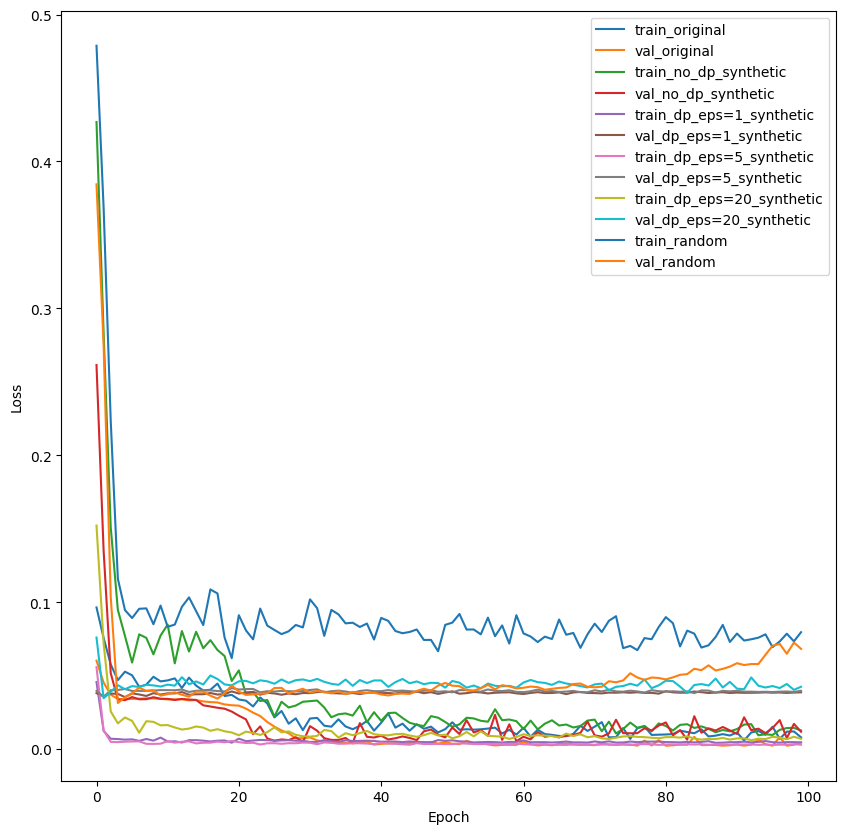

In [64]:
plt.figure(figsize=(10,10))
plt.plot(trainingEpoch_loss, label='train_original')
plt.plot(validationEpoch_loss,label='val_original')
plt.plot(trainingEpoch_no_dp_loss, label='train_no_dp_synthetic')
plt.plot(validationEpoch_no_dp_loss,label='val_no_dp_synthetic')
plt.plot(trainingEpoch_dp_loss, label='train_dp_eps=1_synthetic')
plt.plot(validationEpoch_dp_loss,label='val_dp_eps=1_synthetic')
plt.plot(trainingEpoch_dp_eps5_loss, label='train_dp_eps=5_synthetic')
plt.plot(validationEpoch_dp_eps5_loss,label='val_dp_eps=5_synthetic')
plt.plot(trainingEpoch_dp_eps20_loss, label='train_dp_eps=20_synthetic')
plt.plot(validationEpoch_dp_eps20_loss,label='val_dp_eps=20_synthetic')
plt.plot(trainingEpoch_random_loss, label='train_random')
plt.plot(validationEpoch_random_loss,label='val_random')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show